# Testing the BC Algorithm
## (naively, with on-expert-trajectory data)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from bc import bc

All the policy setup is here. Needs to match the parameters used to train the model originally. 

In [3]:
data_path = "../../sim_mujoco/data/dataset.csv"
policy_name = "bc_policy_1"
# state_columns = [
#     "L_YAW_pos", "L_HAA_pos", "L_HFE_pos", "L_KFE_pos", "L_ANKLE_pos",
#     "R_YAW_pos", "R_HAA_pos", "R_HFE_pos", "R_KFE_pos", "R_ANKLE_pos",
#     "L_YAW_vel", "L_HAA_vel", "L_HFE_vel", "L_KFE_vel", "L_ANKLE_vel",
#     "R_YAW_vel", "R_HAA_vel", "R_HFE_vel", "R_KFE_vel", "R_ANKLE_vel", 
#     "vel_x_BF", "vel_y_BF", "vel_z_BF", "normal_vec_x_BF", "normal_vec_y_BF", "normal_vec_z_BF", 
#     "omega_x", "omega_y", "omega_z", "vx_des_BF", "vy_des_BF", 
#     "right_foot_t_since_contact", "right_foot_t_since_no_contact", 
#     "right_foot_pos_x_BF", "right_foot_pos_y_BF", "right_foot_pos_z_BF",
#     "left_foot_t_since_contact", "left_foot_t_since_no_contact",
#     "left_foot_pos_x_BF", "left_foot_pos_y_BF", "left_foot_pos_z_BF"
# ]
state_columns = [
    "L_YAW_pos", "L_HAA_pos", "L_HFE_pos", "L_KFE_pos", "L_ANKLE_pos",
    "R_YAW_pos", "R_HAA_pos", "R_HFE_pos", "R_KFE_pos", "R_ANKLE_pos",
    "L_YAW_vel", "L_HAA_vel", "L_HFE_vel", "L_KFE_vel", "L_ANKLE_vel",
    "R_YAW_vel", "R_HAA_vel", "R_HFE_vel", "R_KFE_vel", "R_ANKLE_vel", 
    "vel_x_BF", "vel_y_BF", "vel_z_BF", 
    "omega_x", "omega_y", "omega_z", "vx_des_BF", "vy_des_BF", 
    "right_foot_t_since_contact", "right_foot_t_since_no_contact", 
    "right_foot_pos_x_BF", "right_foot_pos_y_BF", "right_foot_pos_z_BF",
    "left_foot_t_since_contact", "left_foot_t_since_no_contact",
    "left_foot_pos_x_BF", "left_foot_pos_y_BF", "left_foot_pos_z_BF"
]
action_columns = [
    "L_YAW_tau_ff", "L_HAA_tau_ff", "L_HFE_tau_ff", "L_KFE_tau_ff", "L_ANKLE_tau_ff",
    "R_YAW_tau_ff", "R_HAA_tau_ff", "R_HFE_tau_ff", "R_KFE_tau_ff", "R_ANKLE_tau_ff",
    "L_YAW_q_des", "L_HAA_q_des", "L_HFE_q_des", "L_KFE_q_des", "L_ANKLE_q_des",
    "R_YAW_q_des", "R_HAA_q_des", "R_HFE_q_des", "R_KFE_q_des", "R_ANKLE_q_des",
    "L_YAW_q_vel des", "L_HAA_q_vel des", "L_HFE_q_vel des", "L_KFE_q_vel des", "L_ANKLE_q_vel des",
    "R_YAW_q_vel des", "R_HAA_q_vel des", "R_HFE_q_vel des", "R_KFE_q_vel des", "R_ANKLE_q_vel des"
]
num_input_states = 3 # Number of states to include in input
policy_arch = [
    {'Layer': 'Linear', 'Input': len(state_columns) * num_input_states, 'Output': 256},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': 256, 'Output': 512},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': 512, 'Output': 256},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': 256, 'Output': len(action_columns)}
]

Format the data so that the policy can predict on the states (on the expert trajectory). No interface with sim, just comparing policy actions with expert actions on expert trajectory. 

In [4]:
dataset = pd.read_csv(data_path)
states = dataset[state_columns].to_numpy(dtype=np.float64)
actions = dataset[action_columns].to_numpy(dtype=np.float64)

# Stack states if more than one included in input
states = np.hstack([states[ii: states.shape[0] - (num_input_states - ii - 1), :] for ii in range(num_input_states)])
actions = actions[num_input_states - 1:, :]

test_states = states[32000:, :]
test_actions = actions[32000:, :]

Predict on the availabe data (which was excluded from training)

In [6]:
# Run vanilla behavior cloning
policy = bc._gen_policy(policy_arch)
policy.load_state_dict(torch.load(f"policies/{policy_name}.pt"))

policy_actions = policy(torch.tensor(test_states, dtype=torch.float32))

And now do some plotting to examine results

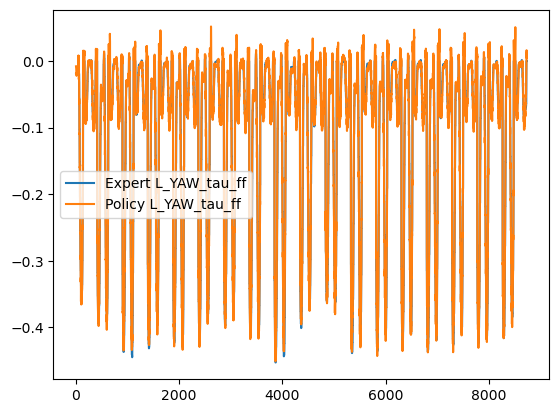

In [8]:
plt.figure()
plt.plot(test_actions[:, 0])
plt.plot(policy_actions[:, 0].detach().numpy())
plt.legend(['Expert L_YAW_tau_ff', 'Policy L_YAW_tau_ff'])
plt.show()

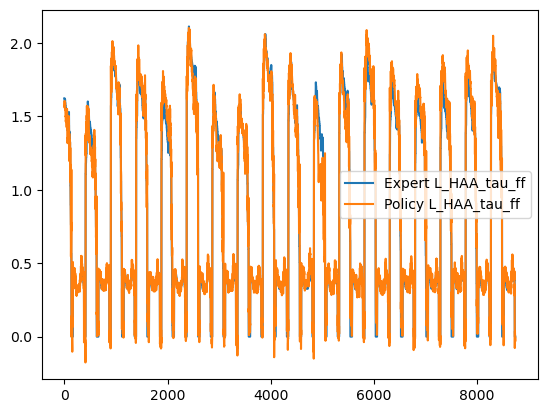

In [9]:
plt.figure()
plt.plot(test_actions[:, 1])
plt.plot(policy_actions[:, 1].detach().numpy())
plt.legend(['Expert L_HAA_tau_ff', 'Policy L_HAA_tau_ff'])
plt.show()

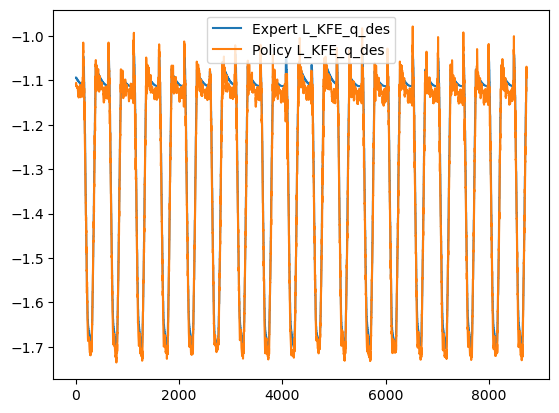

In [10]:
plt.figure()
plt.plot(test_actions[:, 13])
plt.plot(policy_actions[:, 13].detach().numpy())
plt.legend(['Expert L_KFE_q_des', 'Policy L_KFE_q_des'])
plt.show()

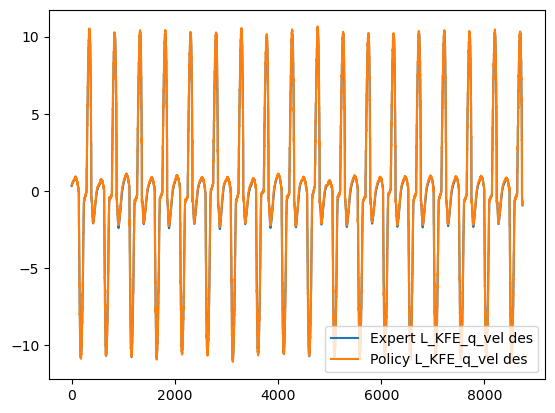

In [11]:
plt.figure()
plt.plot(test_actions[:, 23])
plt.plot(policy_actions[:, 23].detach().numpy())
plt.legend(['Expert L_KFE_q_vel des', 'Policy L_KFE_q_vel des'])
plt.show()